# Skate Music Outline
<center><small>Jared Wilber </small></center>

As a young teen, skateboarding was my life. If I wasn't skating, I watching skate videos, discovering not only my new favourite skaters but my new favourite bands. My first skate video, Blind's Video Days, turned me on not only to the indie rock staples Dinosaur Jr. and Husker Du, but to punk legend's Black Flag and Jazz legend John Coltrane.

Music in skate videos was different than what they played on the radio. It spanned all genes. It felt diverse. It felt counterculture. It felt <i>cool</i>.

This sentiment is not unique. Since its inception in the 1960s, skateboarding and music have been intrinsically linked. While a diverse array of artists explicitly mention skateboarding in their music (Lupe Fiasco, Avril Lavigne, Machine Gun Kelly, NOFX, FIDLAR) an even larger number reference it as an enduring influence, including Ian Mackeye, Ben Harper, Jeff Ament, Yelawolf, Tom Delonge, Pharell Williams, James Hetfield, Matt & KimDevendra Banhart, Tyler the Creator, Lil Wayne,  Coconut Records and Flogging Molly referencing skateboarding as an influence.

What do all of the groups above have in common? At some point, some (or all) members of their group were skateboarders.

Thus, it's clear that skate video music is a sort of powerhouse playlist of influence. What is this playlist composed of? And how has it changed over time?

Naturally, I think this piece lends itself to be more exploratory than analytical.

## Data




Data was obtained from skatevideosite.com, a website that retains information for every skate video released.

In [14]:
suppressMessages(library(tidyverse))
DATA_PATH <- '/Users/jared/Desktop/skateboard_data2.csv'
df <- suppressMessages(read_csv(DATA_PATH))
df$index <- NULL
xtabs(~df$year)

df$year
1985 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 
   1    1   24   14   29  121  149  159  112  240  210  186  355  328  373  414 
2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 
 473  537  788 1072 1145 1257 1061 1076  891  637  579  263  132  127  100 

##### Data Caveats

Skate-videos really took off as a thing in the 90s, and there's not a lot of data for videos in the 80s at all. Moreover, most videos in the 80s used songs from local punk bands.

I want to include as much 80's data as possible, as doing so will reveal the large influence punk had at the time. I think starting from 1989 will be sufficient to show this trend. I can manually enter data for some videos from 1989 to bring the count up.

## Overall look at Artists/Genres Used 

So which artists make up this early tastemaker, and from what genres do they come from?

**Plot Idea**: I can't prototype this plot in R, but I'd like to use a more refined version of the bubble chart I used earlier. Aside from an overall improvement in the aesthetic, it could include an artist's image, sound-bite link, and an informational tool-tip.

- **toggle option 1**: Artist nodes organized by 'broad' genre
- **toggle option 2**: Artist nodes organized by year used
- **possible toggle option 3**: All nodes equi-sized and form waffle chart to show more detailed genre distribution

Each view of the data should include a unique paragraph and annotations for interesting observations 



## How Genre Has Evolved Over Time

Skateboarding has gone through several major shifts over time. From the dogtown era of the 70s, to the vert skating of the 80s, to the 'big pants, little wheels' of the 90s, all the way up to the style-centric focus today, skateboarding has evolved with the times.

As part of this cultural revolution, the music in skateboarding has changed too.


  
**Plot Idea**: Scroller: Show time-series evolve over time, with annotations. 
End of scrolling should end on searchable plot: Type artist and see songs used over time.

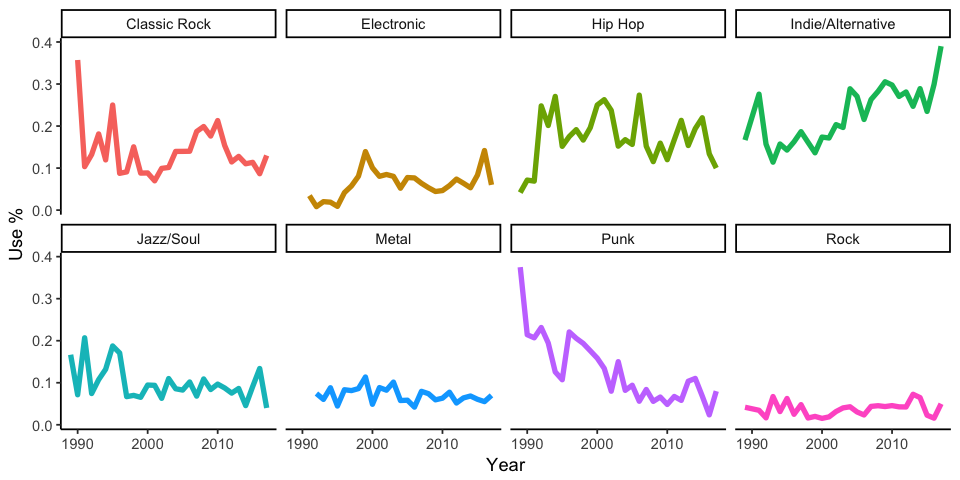

In [72]:
# load data created from clean_genre_script.R
df <- suppressMessages(read_csv('~/Desktop/cleaned_skatedata.csv'))
time_df <- df %>%
  select(genre, year) %>%
  filter(year > 1988) %>%
  group_by(year) %>%
  mutate(year_cnt = n()) %>%
  ungroup() %>%
  group_by(genre, year, year_cnt) %>%
  summarise(gen_cnt = n()) %>%
  ungroup() %>%
  group_by(genre, year) %>%
  summarise(genre_pct = gen_cnt / year_cnt) %>%
  ungroup() %>%
  arrange(year)

options(repr.plot.width=8, repr.plot.height=4)
time_df %>%
filter(!(genre %in% c('Other')),
      !is.na(genre)) %>%
ggplot(aes(x=year, y = genre_pct, color=genre)) +
  geom_line(lwd=1.5) +
  facet_wrap(~genre, nrow = 2)  +
    theme_classic() +
    theme(legend.position="none") +
    xlab('Year') +
    ylab('Use %')

#####  Observations
- Early skate-videos used a lot of Punk Rock. Over time, this consistently decreased.
- Electronic, Rock and Metal are not used  often.
- Begininng wirth the early 90's, Hip Hop was consistently used in skate videos
- Indie & Alternative music took off in the mid 90s, and has dominated ever since. 
- The (relatively) heavy use of Classic Rock is surprising, while the dominance of Hip Hop and Indie/Alternative are not.

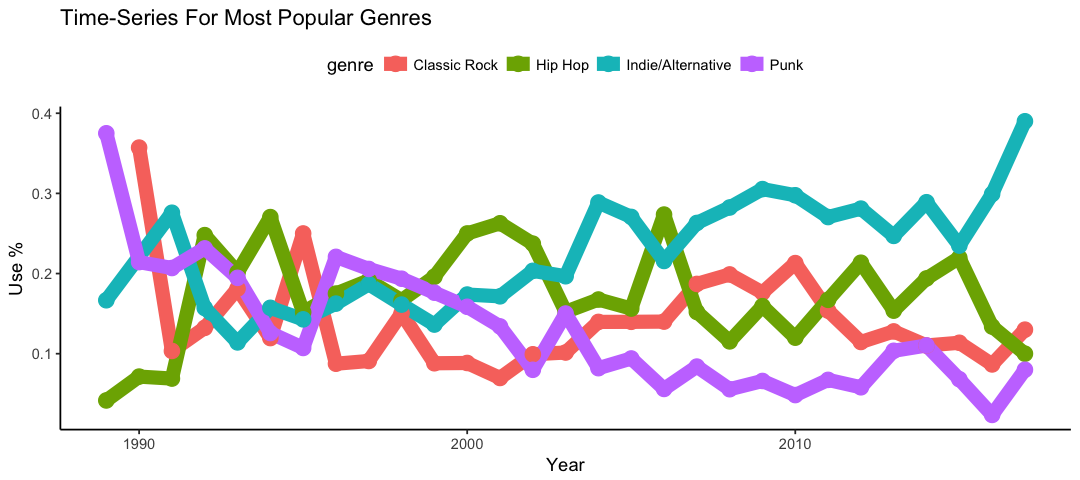

In [74]:
options(repr.plot.width=9, repr.plot.height=4)
time_df %>%
    filter(genre %in% c('Indie/Alternative', 'Punk', 'Hip Hop', 'Classic Rock')) %>%
ggplot(aes(x=year, y = genre_pct, color=genre)) +
  geom_line(lwd=4)  +
geom_point(lwd=4) +
labs(title="Time-Series For Most Popular Genres") +
    theme_classic() +
    theme(legend.position = 'top') +
    xlab('Year') +
    ylab('Use %')



## Come Together

Which artists tend to be used together?

Methodolgy: 
- For each artist, create an embedding of videos appeared in.
- Use cosine similarity to measure artist similarity.

**Plot Idea**: T-SNE scatter plot? Small multiples proportion (search a given artist, see top n similar artists?

In [246]:
library(tidytext)
library(widyr)

DATA_PATH <- '~/Desktop/cleaned_skatedata.csv'
df <- suppressMessages(read_csv(DATA_PATH))

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }
 if (numPlots==1) {
    print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

plot_art_sims <- function(artist_name) {
    df %>%
  select(video, artist) %>%
  filter(!is.na(video),
         !(artist %in% c('?'))) %>%
  arrange(artist) %>% 
  count(artist, video) %>%
  bind_tf_idf(artist, video, n) %>%
  ungroup() %>%
  pairwise_similarity(artist, video, tf_idf) %>%
  arrange(desc(similarity)) %>%
  filter(item1 == artist_name) %>%
  top_n(12)%>%
  ggplot(aes(x=reorder(item2, similarity), y=similarity)) +
  geom_col(fill='coral') +
  labs(x = "Artists", y = "Similarity", title = paste("Artists Often Used With", artist_name)) +
  coord_flip() +
  theme_minimal() +
  theme(legend.position = 'none')
}

Selecting by similarity
Selecting by similarity
Selecting by similarity
Selecting by similarity
Selecting by similarity
Selecting by similarity


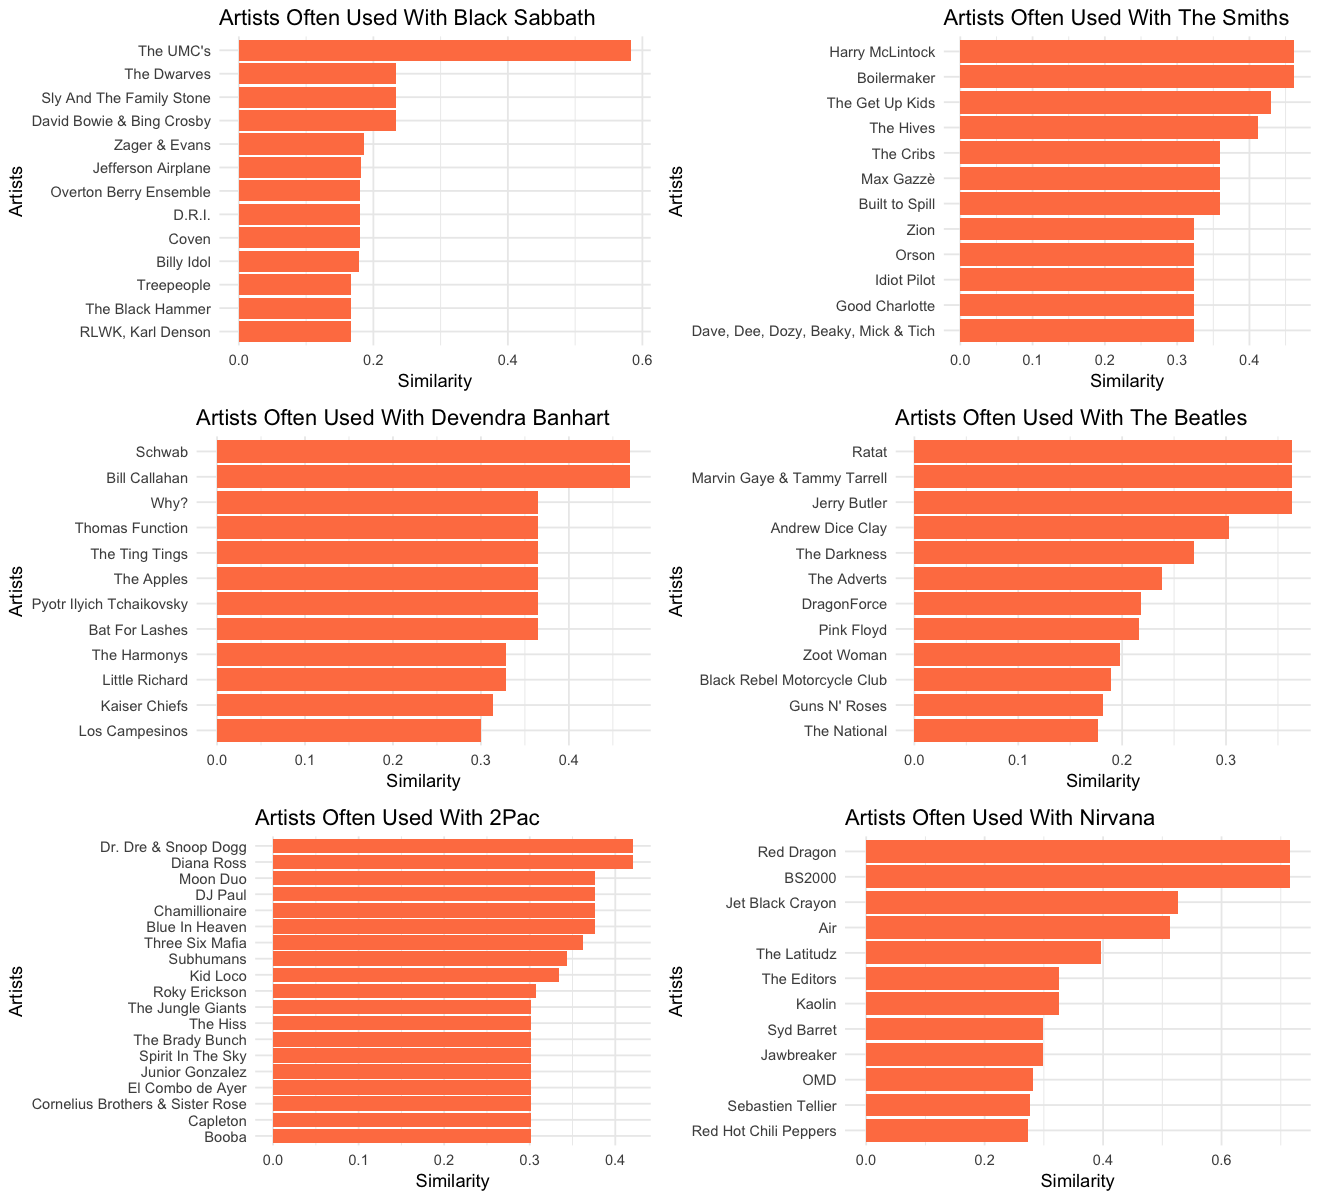

In [247]:
options(repr.plot.width=11, repr.plot.height=10)
p1 <- plot_art_sims('Black Sabbath')
p2 <- plot_art_sims('Devendra Banhart')
p3 <- plot_art_sims('2Pac')
p4 <- plot_art_sims('The Smiths')
p5 <- plot_art_sims('The Beatles')
p6 <- plot_art_sims('Nirvana')
multiplot(p1,p2,p3,p4,p5,p6, cols=2)

# End